In [68]:
import sys
import os
import json
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison

### SPECIFY THE OUTERMOST DIRECTORY CONTAINING ALL MODELS
model_dir = '/om2/user/msaddler/pitchnet/saved_models/'

### SPECIFY RESULTS DICT BASENAME: determines which experiment to plot
# results_dict_basename = 'EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_mooremoore2003_080to480Hz_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_MistunedHarm_v00_bestckpt_results_dict.json'
results_dict_basename = 'EVAL_AltPhase_v01_bestckpt_results_dict.json'


### SPECIFY REGULAR EXPRESSIONS FOR MODELS: (regex, model_name) pairs
master_list = [
#     ('PND_v04_TLAS_classification*/', 'arch_Test PND_v04_TLAS'),
#     ('arch_0628/PND_v04_TLAS_classification*/', 'arch_0628 PND_v04_TLAS'),
#     ('arch_0703/PND_v04_TLAS_classification*/', 'arch_0703 PND_v04_TLAS'),
#     ('PND_v04_TLAS_halflowpassnoise_v02_classification*/', 'arch_Test PND_v04_TLAS_HLPv02'),
#     ('arch_0628/PND_v04_TLAS_halflowpassnoise_v02_classification*/', 'arch_0628 PND_v04_TLAS_HLPv02'),
#     ('arch_0703/PND_v04_TLAS_halflowpassnoise_v02_classification*/', 'arch_0703 PND_v04_TLAS_HLPv02'),

#     ('models_RSB/PND_v04_TLAS_classification*/', 'arch_Test RSB PND_v04_TLAS'),

    ('PND_v04_JWSS_classification*/', 'CarneyModel + JWSS noise'),
    ('models_RSB/PND_v04_JWSS_classification*/', 'RSBModel + JWSS noise'),
    ('PND_v04_TLAS_classification*/', 'CarneyModel + TLAS noise'),
    ('models_RSB/PND_v04_TLAS_classification*/', 'RSBModel + TLAS noise'),

#     ('PND_v04_TLAS_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', 'CarneyModel TLAS noise'),
#     ('models_RSB/PND_v04_TLAS_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', 'RSBModel TLAS noise'),
#     ('PND_v04_JWSS_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', 'CarneyModel JWSS noise'),
#     ('models_RSB/PND_v04_JWSS_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', 'RSBModel JWSS noise'),
    
#     ('PND_v04_JWSS_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', ''),
#     ('PND_v04_JWSS_halflowpassnoise_v00_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '50% lowpass filt noise (100-200Hz)'),
#     ('PND_v04_JWSS_halflowpassnoise_v01_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '50% lowpass filt noise (50-500Hz)'),
#     ('PND_v04_JWSS_halfbandpass_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '50% bandpass filt signal'),
#     ('PND_v04_JWSS_highpass_v00_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '100% highpass filt signal'),

#     ('models_RSB/PND_v04_JWSS_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', ''),
#     ('models_RSB/PND_v04_JWSS_halflowpassnoise_v00_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '50% lowpass filt noise (100-200Hz)'),
#     ('models_RSB/PND_v04_JWSS_halflowpassnoise_v01_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '50% lowpass filt noise (50-500Hz)'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '50% bandpass filt signal'),
    
#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification[0-2]/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Train 1x BW, Test 1x BW'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification[0-2]/EVAL_bernox2005_FixedFilter_bestckpt_test_rsb2xBW_results_dict.json', 'Train 1x BW, Test 2x BW'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification[0-2]/EVAL_bernox2005_FixedFilter_bestckpt_test_rsb3xBW_results_dict.json', 'Train 1x BW, Test 3x BW'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification[0-2]/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Train 1x BW, Test 1x BW'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_rsb2xBW_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Train 2x BW, Test 2x BW'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_rsb2xBW_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Train 3x BW, Test 3x BW'),

#     ('PND_v04_JWSS_classification[0-2]/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Phase-locking up to ~5000 Hz'),
#     ('PND_v04_JWSS_ANlowpass1000Hz_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Phase-locking up to 1000 Hz'),
#     ('PND_v04_JWSS_ANlowpass0050Hz_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Phase-locking up to 50 Hz'),

#     ('PND_v04_JWSS_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', 'Carney model, PND_v04_JWSS'),
#     ('PND_v04_JWSS_halflowpassnoise_v00_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', '50% lowpass filt noise (100-200Hz)'),
#     ('PND_v04_JWSS_halflowpassnoise_v01_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', '50% lowpass filt noise (50-500Hz)'),
#     ('PND_v04_JWSS_halfbandpass_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', '50% bandpass filt signal'),
#     ('PND_v04_JWSS_highpass_v00_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', '100% highpass filt signal'),
    
#     ('models_RSB/PND_v04_JWSS_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', 'RSB model, PND_v04_JWSS'),
#     ('models_RSB/PND_v04_JWSS_halflowpassnoise_v00_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', '50% lowpass filt noise (100-200Hz)'),
#     ('models_RSB/PND_v04_JWSS_halflowpassnoise_v01_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', '50% lowpass filt noise (50-500Hz)'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', '50% bandpass filt signal'),

]

### LOAD PSYCHOPHYSICS EXPERIMENT RESULTS
model_keys = []
results_dicts = {}
master_count = 0
for fn_regex, model_key in master_list:
    results_dicts[model_key] = []
    model_keys.append(model_key)
    if not fn_regex[0] == '/': fn_regex = os.path.join(model_dir, fn_regex)
    if '.json' not in fn_regex: fn_regex = os.path.join(fn_regex, results_dict_basename)
    for results_dict_fn in sorted(glob.glob(fn_regex)):
        master_count = master_count + 1
        with open(results_dict_fn) as f:
            results_dicts[model_key].append(json.load(f))

print('Loaded results from {} files ({})'.format(master_count, results_dict_basename))
for key in results_dicts.keys():
    print(key, len(results_dicts[key]))


Loaded results from 12 files (EVAL_AltPhase_v01_bestckpt_results_dict.json)
CarneyModel + TLAS noise 3
RSBModel + TLAS noise 3
CarneyModel + JWSS noise 3
RSBModel + JWSS noise 3


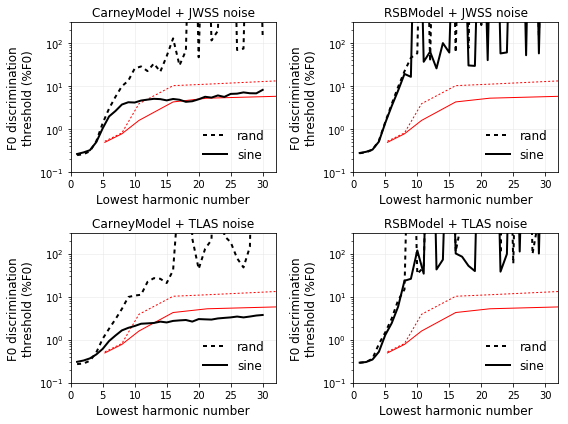

In [58]:
def make_bernox_threshold_plot(ax, results_dict_input,
                               title_str=None,
                               legend_on=True,
                               include_yerr=False,
                               sine_plot_kwargs={},
                               rand_plot_kwargs={}):
    '''
    Function for plotting Bernstein & Oxenham (2005) experiment results:
    F0 discrimination thresholds as a function of lowest harmonic number.
    '''
    if isinstance(results_dict_input, dict):
        results_dict = results_dict_input
        if 'f0dl_stddev' not in results_dict.keys():
            results_dict['f0dl_stddev'] = [0] * len(results_dict['f0dl'])
    elif isinstance(results_dict_input, list):
        f0dls = np.array([rd['f0dl'] for rd in results_dict_input])
        results_dict = {
            'phase_mode': results_dict_input[0]['phase_mode'],
            'low_harm': results_dict_input[0]['low_harm'],
            'f0dl': np.mean(f0dls, axis=0),
            'f0dl_stddev': np.std(f0dls, axis=0),
        }
    else:
        raise ValueError("INVALID results_dict_input")
    
    phase_mode_list = np.array(results_dict['phase_mode'])
    low_harm_list = np.array(results_dict['low_harm'])
    f0dl_list = np.array(results_dict['f0dl'])
    f0dl_stddev_list = np.array(results_dict['f0dl_stddev'])
    unique_phase_modes = np.flip(np.unique(phase_mode_list))
    for phase_mode in unique_phase_modes:
        xval = low_harm_list[phase_mode_list == phase_mode]
        yval = f0dl_list[phase_mode_list == phase_mode]
        yerr = f0dl_stddev_list[phase_mode_list == phase_mode]
        if phase_mode == 0:
            plot_kwargs = {'label': 'sine', 'color': 'b', 'ls':'-', 'lw':2, 'ms':8, 'marker':''}
            plot_kwargs.update(sine_plot_kwargs)
        else:
            plot_kwargs = {'label': 'rand', 'color': 'b', 'ls':'--', 'lw':2, 'ms':8, 'marker':''}
            plot_kwargs.update(rand_plot_kwargs)
        if not legend_on: plot_kwargs['label'] = None
        if include_yerr:
            ax.fill_between(xval, yval-yerr, yval+yerr, alpha=0.15,
                            facecolor=plot_kwargs.get('color', 'k'))
        ax.plot(xval, yval, **plot_kwargs)

    ax.set_yscale('log')
    ax.set_ylim([1e-1, 3e2])
    ax.set_xlim([0, 32])
    ax.set_xticks(np.arange(0, 31, 5))
    ax.set_xlabel('Lowest harmonic number', fontsize=12)
    ax.set_ylabel('F0 discrimination\nthreshold (%F0)', fontsize=12)
    if title_str is not None: ax.set_title(title_str, fontsize=12)
    if legend_on: ax.legend(loc='lower right', frameon=False, fontsize=12)
    return results_dict



human_results_dict = util_human_model_comparison.get_human_results_dict_bernox2005(average_conditions=True)

NCOLS = 2
NROWS = int(np.ceil(len(model_keys) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))
# ax_arr = np.transpose(ax_arr)
ax_arr = ax_arr.flatten()

for idx, model_key in enumerate(model_keys):
    results_dict_input = results_dicts[model_key]
    ax = ax_arr[idx]
    title_str=model_key
    
    make_bernox_threshold_plot(ax, human_results_dict,
                               title_str=None, legend_on=False,
                               sine_plot_kwargs={'color':'r', 'lw':0.5*2},
                               rand_plot_kwargs={'color':'r', 'lw':0.5*2, 'dashes':(2, 2)})
    make_bernox_threshold_plot(ax, results_dict_input,
                               title_str=title_str, legend_on=True,
                               include_yerr=False,
                               sine_plot_kwargs={'color':'k', 'lw':2},
                               rand_plot_kwargs={'color':'k', 'lw':2, 'dashes':(2, 2)})
    ax.grid(color=[0.9, 0.9, 0.9], linestyle='-', linewidth=0.5)

for idx in range(len(model_keys), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('figures/2019SEP25_PNDv04_JWSSvsTLAS_CarneyvsRSB_bernox.pdf', bbox_inches='tight')



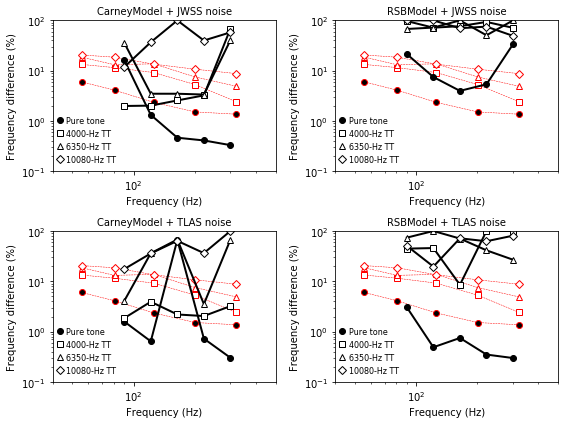

In [61]:
def make_TT_threshold_plot(ax, results_dict_input,
                           title_str=None,
                           legend_on=True,
                           include_yerr=False,
                           plot_kwargs_update={},
                           threshold_cap=100.0):
    '''
    Function for plotting transposed tones discrimination experiment results:
    F0 discrimination thresholds as a function of frequency.
    '''
    if isinstance(results_dict_input, dict):
        results_dict = results_dict_input
        if 'f0dl_stddev' not in results_dict.keys():
            results_dict['f0dl_stddev'] = [0] * len(results_dict['f0dl'])
        f0dls = np.array(results_dict['f0dl'])
        if threshold_cap is not None:
            f0dls[f0dls > threshold_cap] = threshold_cap
        results_dict['f0dl'] = f0dls
    elif isinstance(results_dict_input, list):
        f0dls = np.array([rd['f0dl'] for rd in results_dict_input])
        if threshold_cap is not None:
            f0dls[f0dls > threshold_cap] = threshold_cap
        results_dict = {
            'f0_ref': results_dict_input[0]['f0_ref'],
            'f_carrier': results_dict_input[0]['f_carrier'],
            'f0dl': np.mean(f0dls, axis=0),
            'f0dl_stddev': np.std(f0dls, axis=0),
        }
    else:
        raise ValueError("INVALID results_dict_input")
    
    f0_ref = np.array(results_dict['f0_ref'])
    f_carrier_list = np.array(results_dict['f_carrier'])
    f0dl_list = np.array(results_dict['f0dl'])
    f0dl_stddev_list = np.array(results_dict['f0dl_stddev'])
    unique_f_carrier_list = np.unique(f_carrier_list)
    for f_carrier in unique_f_carrier_list:
        xval = f0_ref[f_carrier_list == f_carrier]
        yval = f0dl_list[f_carrier_list == f_carrier]
        yerr = f0dl_stddev_list[f_carrier_list == f_carrier]
        if f_carrier > 0:
            label = '{}-Hz TT'.format(int(f_carrier))
            plot_kwargs = {'label': label, 'color': 'k', 'ls':'-', 'lw':2, 'ms':6,
                           'marker':'o', 'markerfacecolor': 'w'}
            if int(f_carrier) == 10080: plot_kwargs['marker'] = 'D'
            if int(f_carrier) == 6350: plot_kwargs['marker'] = '^'
            if int(f_carrier) == 4000: plot_kwargs['marker'] = 's'
        else:
            label = 'Pure tone'
            plot_kwargs = {'label': label, 'color': 'k', 'ls':'-', 'lw':2, 'ms':6,
                           'marker':'o', 'markerfacecolor': 'k'}
        if not legend_on: plot_kwargs['label'] = None
        plot_kwargs.update(plot_kwargs_update)
        if include_yerr:
            ax.fill_between(xval, yval-yerr, yval+yerr, alpha=0.15,
                            facecolor=plot_kwargs.get('color', 'k'))
        ax.plot(xval, yval, **plot_kwargs)

    ax.set_yscale('log')
    ax.set_ylim([1e-1, 1e2])
    ax.set_xscale('log')
    ax.set_xlim([40, 500])
    ax.set_xlabel('Frequency (Hz)', fontsize=10)
    ax.set_ylabel('Frequency difference (%)', fontsize=10)
    if title_str is not None: ax.set_title(title_str, fontsize=10)
    if legend_on: ax.legend(loc='lower left', frameon=False, fontsize=8, handlelength=0)
    return results_dict


human_results_dict = util_human_model_comparison.get_human_results_dict_transposedtones()

NCOLS = 2
NROWS = int(np.ceil(len(model_keys) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))
# ax_arr = np.transpose(ax_arr)
ax_arr = ax_arr.flatten()

for idx, model_key in enumerate(model_keys):
    results_dict_input = results_dicts[model_key]
    ax = ax_arr[idx]
    title_str=model_key
    
    make_TT_threshold_plot(ax, human_results_dict,
                           title_str=None, legend_on=False,
                           plot_kwargs_update={'color': 'r', 'ls':'--', 'lw':0.5, 'ms':6})
    make_TT_threshold_plot(ax, results_dict_input,
                           title_str=title_str,
                           legend_on=True,
                           include_yerr=False)

for idx in range(len(model_keys), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('figures/2019SEP25_PNDv04_JWSSvsTLAS_CarneyvsRSB_transposedtones.pdf', bbox_inches='tight')


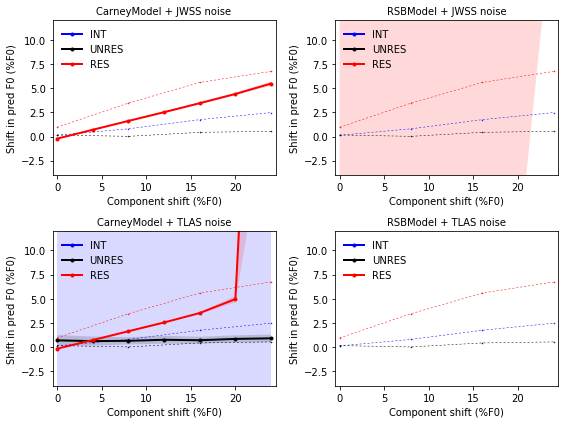

In [64]:
def make_freqshiftedcomplexes_plot(ax, results_dict_input,
                                   expt_key='spectral_envelope_centered_harmonic',
                                   pitch_shift_key='f0_pred_shift_median',
                                   pitch_shift_key_stddev=None,
                                   condition_plot_kwargs={},
                                   plot_kwargs_update={},
                                   title_str=None,
                                   legend_on=True,
                                   include_yerr=False):
    '''
    Function for plotting frequency-shifted complexes experiment results:
    F0 shift as a function of frequency shift.
    '''
    if pitch_shift_key_stddev is None: pitch_shift_key_stddev = pitch_shift_key + '_stddev'
    if isinstance(results_dict_input, dict):
        results_dict = results_dict_input
        for condition in results_dict[expt_key].keys():
            if pitch_shift_key_stddev not in results_dict[expt_key][condition].keys():
                dummy_vals = [0] * len(results_dict[expt_key][condition][pitch_shift_key])
                results_dict[expt_key][condition][pitch_shift_key_stddev] = dummy_vals

    elif isinstance(results_dict_input, list):
        rd0 = results_dict_input[0]
        results_dict = {expt_key: {}}
        for key in rd0.keys():
            if not key == expt_key: results_dict[key] = rd0[key]
        
        for condition in rd0[expt_key].keys():
            plot_vals = np.array([rd[expt_key][condition][pitch_shift_key] for rd in results_dict_input])
            results_dict[expt_key][condition] = {
                'f0_shift': rd0[expt_key][condition]['f0_shift'],
                pitch_shift_key: np.mean(plot_vals, axis=0),
                pitch_shift_key_stddev: np.std(plot_vals, axis=0),
            }
    else:
        raise ValueError("INVALID results_dict_input")
    
    if not condition_plot_kwargs:
        condition_plot_kwargs = {
            '5': {'label': 'RES', 'color': 'r', 'marker': '.', 'ms':6, 'ls':'-', 'lw': 2},
            '11': {'label': 'INT', 'color': 'b', 'marker': '.', 'ms':6, 'ls':'-', 'lw': 2},
            '16': {'label': 'UNRES', 'color': 'k', 'marker': '.', 'ms':6, 'ls':'-', 'lw': 2},
        }
    
    assert set(results_dict[expt_key].keys()) == set(condition_plot_kwargs.keys())
    for condition in sorted(results_dict[expt_key].keys()):
        xval = np.array(results_dict[expt_key][condition]['f0_shift'])
        yval = np.array(results_dict[expt_key][condition][pitch_shift_key])
        yerr = np.array(results_dict[expt_key][condition][pitch_shift_key_stddev])
        plot_kwargs = condition_plot_kwargs[condition]
        plot_kwargs.update(plot_kwargs_update)
        if not legend_on: plot_kwargs['label'] = None
        if include_yerr:
            ax.fill_between(xval, yval-yerr, yval+yerr, alpha=0.15,
                            facecolor=plot_kwargs.get('color', 'k'))
        ax.plot(xval, yval, **plot_kwargs)

    if legend_on: ax.legend(loc='upper left', frameon=False, fontsize=10)
    if title_str: ax.set_title(title_str, fontsize=10)
    ax.set_xlabel('Component shift (%F0)', fontsize=10)
    ax.set_ylabel('Shift in pred F0 (%F0)', fontsize=10)
    ax.set_xlim([-0.5, 24.5])
    ax.set_ylim([-4, 12])
    return results_dict


human_results_dict = util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes(average_conditions=True)

NCOLS = 2
NROWS = int(np.ceil(len(model_keys) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))
# ax_arr = np.transpose(ax_arr)
ax_arr = ax_arr.flatten()

for idx, model_key in enumerate(model_keys):
    results_dict_input = results_dicts[model_key]
    ax = ax_arr[idx]
    title_str=model_key
    
    make_freqshiftedcomplexes_plot(ax, human_results_dict,
                                   expt_key='spectral_envelope_centered_harmonic',
                                   pitch_shift_key='f0_pred_shift_median',
                                   condition_plot_kwargs={},
                                   plot_kwargs_update={'ls':'--', 'lw': 0.5, 'ms':1, 'dashes':(4, 4)},
                                   legend_on=False,
                                   include_yerr=True)
    make_freqshiftedcomplexes_plot(ax, results_dict_input,
                                   expt_key='spectral_envelope_centered_harmonic',
                                   pitch_shift_key='f0_pred_shift_median',
                                   pitch_shift_key_stddev=None,
                                   condition_plot_kwargs={},
                                   plot_kwargs_update={},
                                   title_str=title_str,
                                   legend_on=True,
                                   include_yerr=True)

for idx in range(len(model_keys), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('figures/2019SEP25_PNDv04_JWSSvsTLAS_CarneyvsRSB_freqshiftedcomplexes.pdf', bbox_inches='tight')


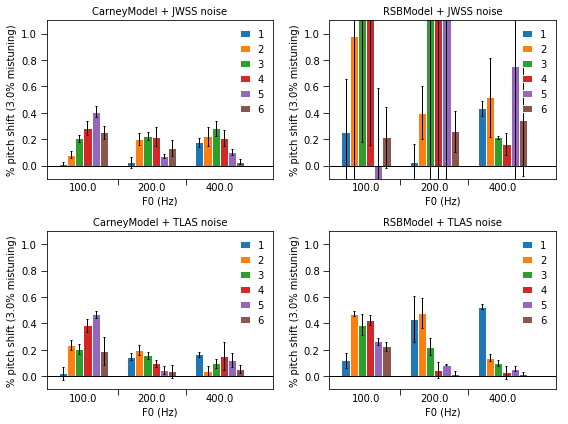

In [67]:
def make_mistuned_harmonics_bar_graph(ax, results_dict_input,
                                      mistuned_pct=3.0,
                                      use_relative_shift=True,
                                      pitch_shift_key='f0_pred_pct_median',
                                      pitch_shift_key_stddev=None,
                                      title_str=None,
                                      legend_on=True,
                                      include_yerr=False,
                                      barwidth=0.12,
                                      harmonic_list=[1,2,3,4,5,6]):
    '''
    Function for plotting mistuned harmonics experiment results:
    F0 shift bar graph for a given mistuning percent.
    '''
    if pitch_shift_key_stddev is None: pitch_shift_key_stddev = pitch_shift_key + '_stddev'
    if isinstance(results_dict_input, dict):
        results_dict = results_dict_input
        bg_results_dict = util_human_model_comparison.get_mistuned_harmonics_bar_graph_results_dict(
            results_dict,
            mistuned_pct=mistuned_pct,
            pitch_shift_key=pitch_shift_key,
            harmonic_list=harmonic_list,
            use_relative_shift=use_relative_shift)
        for group_key in bg_results_dict.keys():
            if pitch_shift_key_stddev not in bg_results_dict[group_key].keys():
                dummy_vals = [0] * len(bg_results_dict[group_key][pitch_shift_key])
                bg_results_dict[group_key][pitch_shift_key_stddev] = dummy_vals
    elif isinstance(results_dict_input, list):
        bg_results_dict_list = []
        for results_dict in results_dict_input:
            bg_results_dict_list.append(
                util_human_model_comparison.get_mistuned_harmonics_bar_graph_results_dict(
                    results_dict,
                    mistuned_pct=mistuned_pct,
                    pitch_shift_key=pitch_shift_key,
                    harmonic_list=harmonic_list,
                    use_relative_shift=use_relative_shift)
            )
        bg_results_dict = {}
        for group_key in bg_results_dict_list[0].keys():
            plot_vals = np.array([bgrd[group_key][pitch_shift_key]
                                  for bgrd in bg_results_dict_list])
            bg_results_dict[group_key] = {
                'f0_ref': bg_results_dict_list[0][group_key]['f0_ref'],
                pitch_shift_key: np.mean(plot_vals, axis=0),
                pitch_shift_key_stddev: np.std(plot_vals, axis=0),
            }
    else:
        raise ValueError("INVALID results_dict_input")

    num_groups = len(bg_results_dict.keys())
    group_xoffsets = np.arange(num_groups) - np.mean(np.arange(num_groups))
    for group_idx, group_key in enumerate(sorted(bg_results_dict.keys())):
        bars_per_group = len(bg_results_dict[group_key]['f0_ref'])
        xval = np.arange(bars_per_group)
        xval = xval + barwidth*group_xoffsets[group_idx]
        yval = np.array(bg_results_dict[group_key][pitch_shift_key])
        yerr = np.array(bg_results_dict[group_key][pitch_shift_key_stddev])
        plot_kwargs = {'width': barwidth, 'edgecolor':'w', 'label':group_key}
        if not legend_on: plot_kwargs['label'] = None
        if include_yerr:
            plot_kwargs['yerr'] = yerr
            plot_kwargs['error_kw'] = {'ecolor': 'k', 'elinewidth':1, 'capsize':1}
        ax.bar(xval, yval, **plot_kwargs)

    base_xvals = np.arange(bars_per_group)
    f0_ref_values = bg_results_dict[group_key]['f0_ref']
    
    ax.axhline(y=0, xmin=0, xmax=1, color='k', lw=1)
    if title_str: ax.set_title(title_str, fontsize=10)
    if legend_on: ax.legend(loc='upper right', frameon=False, fontsize=10, handlelength=1)
    ax.set_xlim([barwidth*group_xoffsets[0]-2*barwidth,
                 np.max(base_xvals) + barwidth*group_xoffsets[-1] + 4*barwidth])
    ax.set_xlabel('F0 (Hz)')
    ax.set_xticks(base_xvals, minor=True)
    ax.set_xticklabels(f0_ref_values, minor=True)
    ax.tick_params(which='minor', length=0)
    ax.set_xticks(base_xvals[:-1]+0.5, minor=False)
    ax.set_xticklabels([], minor=False)
    ax.tick_params(which='major', length=6)
    ax.set_ylim([-0.1, 1.1])
    ax.set_ylabel('% pitch shift ({:.1f}% mistuning)'.format(mistuned_pct))
    return bg_results_dict


human_results_dict = util_human_model_comparison.get_human_results_dict_mistunedharmonics()
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4*1, 3*1))
# make_mistuned_harmonics_bar_graph(ax, human_results_dict,
#                                   pitch_shift_key='f0_pred_pct_median',
#                                   title_str='Humans (Moore 1985)',
#                                   legend_on=True)
# plt.show()


NCOLS = 2
NROWS = int(np.ceil(len(model_keys) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))
# ax_arr = np.transpose(ax_arr)
ax_arr = ax_arr.flatten()

for idx, model_key in enumerate(model_keys):
    results_dict_input = results_dicts[model_key]
    ax = ax_arr[idx]
    title_str=model_key
    
    make_mistuned_harmonics_bar_graph(ax, results_dict_input,
                                      mistuned_pct=3.0,
                                      pitch_shift_key='f0_pred_pct_median',
                                      pitch_shift_key_stddev=None,
                                      title_str=title_str,
                                      legend_on=True,
                                      include_yerr=True,
                                      barwidth=0.12,
                                      harmonic_list=[1,2,3,4,5,6])

for idx in range(len(model_keys), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('figures/2019SEP25_PNDv04_JWSSvsTLAS_CarneyvsRSB_mistunedharmonics.pdf', bbox_inches='tight')


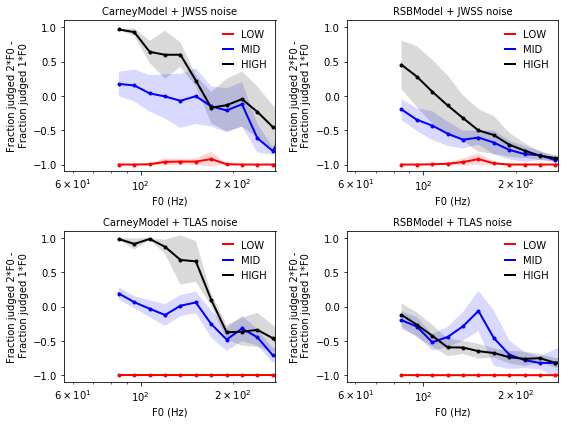

In [70]:
def make_altphase_plot(ax, results_dict_input,
                       expt_key='filter_fl_bin_means',
                       expt_key_stddev=None,
                       condition_plot_kwargs={},
                       plot_kwargs_update={},
                       title_str=None,
                       legend_on=True,
                       include_yerr=False):
    '''
    '''
    if expt_key_stddev is None: expt_key_stddev = expt_key + '_stddev'
    if isinstance(results_dict_input, dict):
        results_dict = results_dict_input
        if expt_key_stddev not in results_dict.keys():
            results_dict[expt_key_stddev] = {}
            for condition in results_dict[expt_key].keys():
                results_dict[expt_key_stddev][condition] = [0] * len(results_dict[expt_key][condition])
    elif isinstance(results_dict_input, list):
        results_dict = {
            'f0_bin_centers': results_dict_input[0]['f0_bin_centers'],
            expt_key: {},
            expt_key_stddev: {},
        }
        for condition in results_dict_input[0][expt_key].keys():
            yvals = np.array([rd[expt_key][condition] for rd in results_dict_input])
            results_dict[expt_key][condition] = np.mean(yvals, axis=0)
            results_dict[expt_key_stddev][condition] = np.std(yvals, axis=0)
    else:
        raise ValueError("INVALID results_dict_input")
    
    if not condition_plot_kwargs:
        condition_plot_kwargs = {
            '125.0': {'label': 'LOW', 'color': 'r', 'marker': '.', 'ms':6, 'ls':'-', 'lw': 2},
            '1375.0': {'label': 'MID', 'color': 'b', 'marker': '.', 'ms':6, 'ls':'-', 'lw': 2},
            '3900.0': {'label': 'HIGH', 'color': 'k', 'marker': '.', 'ms':6, 'ls':'-', 'lw': 2},
        }
    
    assert set(results_dict[expt_key].keys()) == set(condition_plot_kwargs.keys())
    for condition in sorted(results_dict[expt_key].keys()):
        xval = np.array(results_dict['f0_bin_centers'])
        yval = np.array(results_dict[expt_key][condition])
        yerr = np.array(results_dict[expt_key_stddev][condition])
        plot_kwargs = condition_plot_kwargs[condition]
        plot_kwargs.update(plot_kwargs_update)
        if not legend_on: plot_kwargs['label'] = None
        if include_yerr:
            ax.fill_between(xval, yval-yerr, yval+yerr, alpha=0.15,
                            facecolor=plot_kwargs.get('color', 'k'))
        ax.plot(xval, yval, **plot_kwargs)
    
    if legend_on: ax.legend(loc=0, frameon=False, fontsize=10,
                            handlelength=1, markerscale=0)
    if title_str: ax.set_title(title_str, fontsize=10)
    ax.set_xscale('log')
    ax.set_xlabel('F0 (Hz)', fontsize=10)
    ax.set_ylabel('Fraction judged 2*F0 -\n Fraction judged 1*F0', fontsize=10)
    ax.set_xlim([62.5*0.9, 250*1.1])
    ax.set_ylim([-1.1, 1.1])
    return results_dict

human_results_dict = util_human_model_comparison.get_human_results_dict_altphasecomplexes(average_conditions=False)
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4*1, 3*1))
# make_altphase_plot(ax, human_results_dict,
#                    expt_key='filter_fl_bin_means',
#                    expt_key_stddev=None,
#                    condition_plot_kwargs={},
#                    plot_kwargs_update={},
#                    title_str=None,
#                    legend_on=True,
#                    include_yerr=True)
# plt.show()

NCOLS = 2
NROWS = int(np.ceil(len(model_keys) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))
# ax_arr = np.transpose(ax_arr)
ax_arr = ax_arr.flatten()

for idx, model_key in enumerate(model_keys):
    results_dict_input = results_dicts[model_key]
    ax = ax_arr[idx]
    title_str=model_key
    
    make_altphase_plot(ax, results_dict_input,
                       expt_key='filter_fl_bin_means',
                       expt_key_stddev=None,
                       condition_plot_kwargs={},
                       plot_kwargs_update={},
                       title_str=title_str,
                       legend_on=True,
                       include_yerr=True)

for idx in range(len(model_keys), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('figures/2019SEP25_PNDv04_JWSSvsTLAS_CarneyvsRSB_altphasecomplexes.pdf', bbox_inches='tight')

